# Efficient Frontier — S&P 500 Technology (Manual Ticker List, One-by-One Download)

This notebook computes the **Markowitz mean–variance efficient frontier** for a **manually specified list** of tickers (intended to match your pasted S&P 500 Information Technology table).

**Prices:** downloaded **one ticker at a time** from Yahoo Finance via `yfinance`, with `auto_adjust=True` (so the **Close** column is split/dividend-adjusted).



## 2) Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import cvxpy as cp

from sklearn.covariance import LedoitWolf
from scipy.cluster.hierarchy import linkage, leaves_list

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

ANNUALIZATION = 252

def dot_to_dash(ticker: str) -> str:
    return ticker.replace(".", "-")


## 3) Parameters

In [2]:
START = "2005-01-01"
END   = None
MIN_HISTORY_DAYS = 252

LONG_ONLY = True
RF = 0.05
N_FRONTIER = 60

SLEEP_BETWEEN = 0.25
RETRIES = 2

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)


In [3]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, Tuple, Optional
import time
import pandas as pd


def _download_close(
    tickers: Iterable[str],
    start: str,
    end: str,
    *,
    auto_adjust: bool = True,
) -> pd.DataFrame:
    """
    Returns a DataFrame whose columns are tickers and values are (adjusted) closes.

    If auto_adjust=True: uses 'Close' (already adjusted).
    If auto_adjust=False: prefers 'Adj Close' when available, else 'Close'.
    """
    import yfinance as yf

    tickers = list(tickers)
    data = yf.download(
        tickers=tickers,
        start=start,
        end=end,                # end is typically exclusive in yfinance
        interval="1d",
        auto_adjust=auto_adjust,
        progress=False,
        group_by="column",
        actions=False,
        threads=False,          # keep deterministic / kinder to the endpoint
    )

    if data is None or data.empty:
        raise ValueError("Empty download. Check tickers/dates/connectivity.")

    # Choose which field to extract from level-0 (MultiIndex) or columns (flat)
    if auto_adjust:
        preferred = ["Close"]              # adjusted close lives here
    else:
        preferred = ["Adj Close", "Close"] # prefer Adj Close if present

    if isinstance(data.columns, pd.MultiIndex):
        lvl0 = data.columns.get_level_values(0)
        field = next((f for f in preferred if f in lvl0), None)
        if field is None:
            raise ValueError(f"None of {preferred} found in MultiIndex columns level 0.")
        out = data[field].copy()  # columns should be tickers
    else:
        field = next((f for f in preferred if f in data.columns), None)
        if field is None:
            raise ValueError(f"None of {preferred} found in columns.")
        out = data[[field]].copy()
        # when 1 ticker, yfinance returns a single column; rename it to the ticker
        out.columns = tickers

    out.index = pd.to_datetime(out.index)
    out = out.sort_index()
    return out


def download_one_by_one(
    tickers: Iterable[str],
    start: str,
    end: str,
    *,
    auto_adjust: bool = True,
    sleep: float = 0.25,
    retries: int = 3,
) -> Tuple[pd.DataFrame, list[tuple[str, str]]]:
    """
    Downloads each ticker separately, returns (prices, failed).
    prices: Date index, columns=tickers, values=close.
    failed: list of (ticker, error_message)
    """
    tickers = list(tickers)
    frames = []
    failed: list[tuple[str, str]] = []

    for i, t in enumerate(tickers, 1):
        err: Optional[str] = None
        for k in range(retries + 1):
            try:
                df = _download_close([t], start, end, auto_adjust=auto_adjust)
                # ensure single column named t
                if df.shape[1] != 1:
                    df = df.iloc[:, [0]]
                df.columns = [t]
                frames.append(df)
                err = None
                break
            except Exception as e:
                err = str(e)
                time.sleep(sleep * (k + 1))
        if err is not None:
            failed.append((t, err))

        if sleep:
            time.sleep(sleep)

        if i % 10 == 0 or i == len(tickers):
            print(f"{i}/{len(tickers)} downloaded | ok={len(frames)} | failed={len(failed)}")

    if not frames:
        raise RuntimeError("No tickers downloaded successfully.")

    prices = pd.concat(frames, axis=1).sort_index()
    prices = prices.loc[:, ~prices.columns.duplicated()]
    return prices, failed


In [4]:
TECH_TICKERS = [
    "NVDA", "TSLA", "MSFT", "AAPL", "GOOG", "META", "AMZN"
]

START = "2005-01-01"
END = (pd.Timestamp.today().normalize() + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

prices, failed = download_one_by_one(
    TECH_TICKERS,
    start=START,
    end=END,
    auto_adjust=True,
    sleep=0.5,     
    retries=5,
)

print(prices.shape)
failed[:10] if failed else "No failures"
prices.to_csv("Tech_industry_prices-2005.csv")

7/7 downloaded | ok=7 | failed=0
(5301, 7)


In [28]:
prices.to_csv("Tickers.csv")

In [5]:
prices

,NVDA,TSLA,MSFT,AAPL,GOOG,META,AMZN
Date,,,,,,,
2005-01-03,0.180158,NaN,18.420414,0.949067,5.011241,NaN,2.226000
2005-01-04,0.171677,NaN,18.489298,0.958814,4.808279,NaN,2.107000
2005-01-05,0.173282,NaN,18.447969,0.967211,4.783806,NaN,2.088500
2005-01-06,0.171601,NaN,18.427294,0.967961,4.661189,NaN,2.052500
2005-01-07,0.168315,NaN,18.372187,1.038440,4.792211,NaN,2.116000
...,...,...,...,...,...,...,...
2026-01-22,184.839996,449.359985,451.140015,248.350006,330.839996,647.630005,234.339996
2026-01-23,187.669998,449.059998,465.950012,248.039993,328.429993,658.760010,239.160004
2026-01-26,186.470001,435.200012,470.279999,255.410004,333.589996,672.359985,238.419998


## 6) Coverage + missingness

No failed tickers.


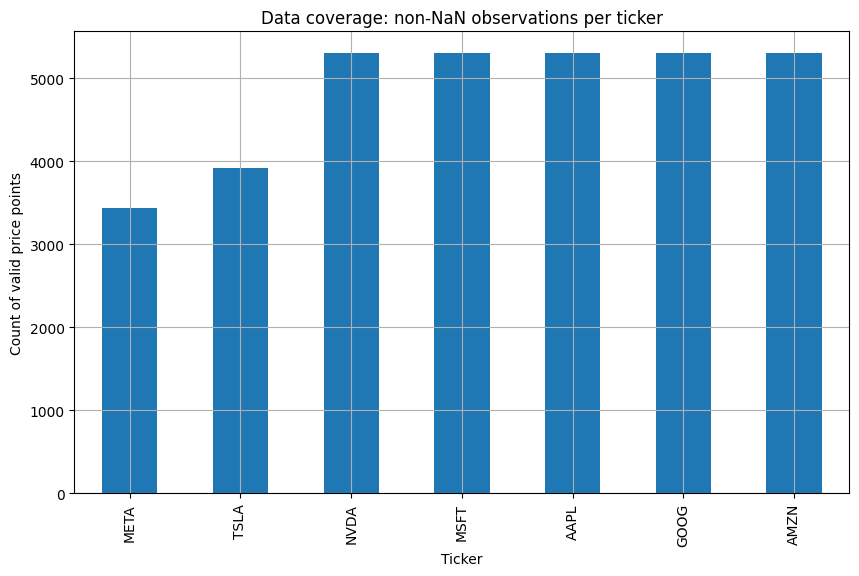

In [6]:
if failed:
    failed_df = pd.DataFrame(failed, columns=["Ticker","Error"])
    display(failed_df)
else:
    print("No failed tickers.")

coverage = prices.notna().sum().sort_values()
fig, ax = plt.subplots()
coverage.plot(kind="bar", ax=ax)
ax.set_title("Data coverage: non-NaN observations per ticker")
ax.set_ylabel("Count of valid price points")
ax.set_xlabel("Ticker")
plt.show()


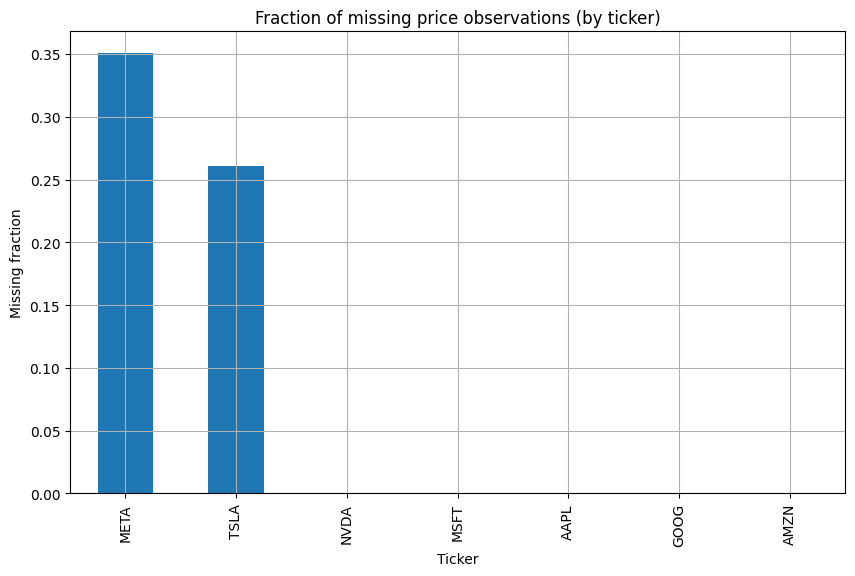

Tickers before filter: 7
Tickers after  filter: 7


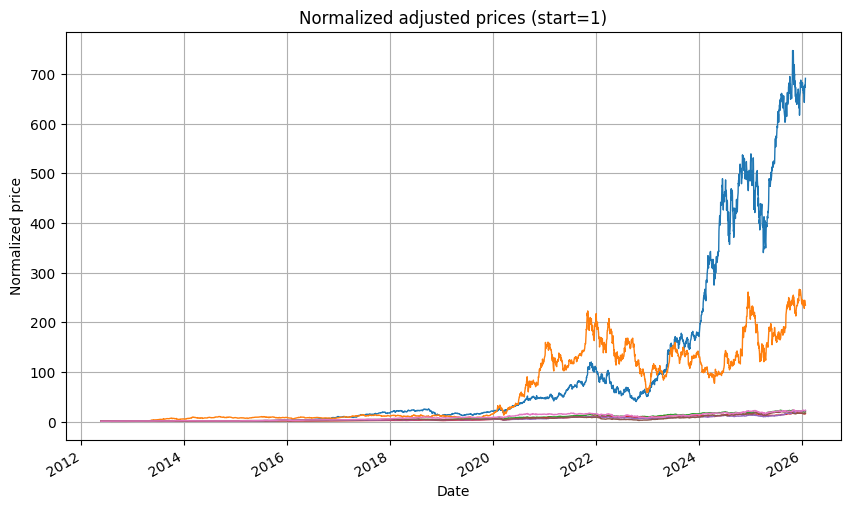

In [7]:
missing_frac = prices.isna().mean().sort_values(ascending=False)

fig, ax = plt.subplots()
missing_frac.plot(kind="bar", ax=ax)
ax.set_title("Fraction of missing price observations (by ticker)")
ax.set_ylabel("Missing fraction")
ax.set_xlabel("Ticker")
plt.show()

valid = (prices.notna().sum() >= MIN_HISTORY_DAYS)
prices_f = prices.loc[:, valid].copy()

print(f"Tickers before filter: {prices.shape[1]}")
print(f"Tickers after  filter: {prices_f.shape[1]}")

prices_f = prices_f.ffill().dropna()

norm = prices_f / prices_f.iloc[0]
fig, ax = plt.subplots()
norm.plot(ax=ax, legend=False, linewidth=1)
ax.set_title("Normalized adjusted prices (start=1)")
ax.set_ylabel("Normalized price")
plt.show()


## 7) Returns + moments

In [8]:
rets = np.log(prices_f / prices_f.shift(1)).dropna()

mu = rets.mean() * ANNUALIZATION
Sigma = rets.cov() * ANNUALIZATION

lw = LedoitWolf().fit(rets.values)
Sigma_lw = pd.DataFrame(lw.covariance_ * ANNUALIZATION, index=rets.columns, columns=rets.columns)

print("Returns shape:", rets.shape)
mu.describe()


Returns shape: (3442, 7)


count    7.000000
mean     0.281587
std      0.110455
min      0.203544
25%      0.216002
50%      0.228458
75%      0.314173
max      0.478752
dtype: float64

## 8) Diagnostics

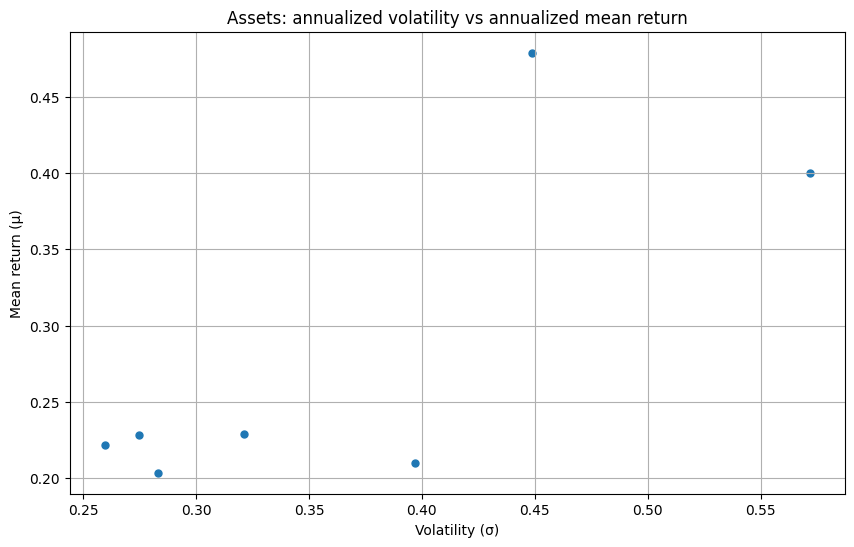

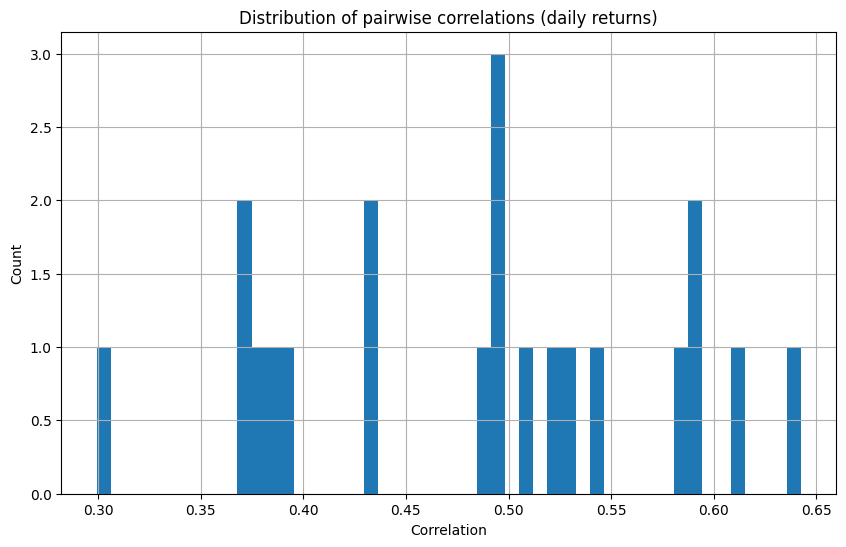

In [9]:
vol = np.sqrt(np.diag(Sigma.values))
asset_stats = pd.DataFrame({"mu": mu.values, "sigma": vol}, index=mu.index)

fig, ax = plt.subplots()
ax.scatter(asset_stats["sigma"], asset_stats["mu"], s=25)
ax.set_title("Assets: annualized volatility vs annualized mean return")
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Mean return (μ)")
plt.show()

corr = rets.corr()
corr_vals = corr.values[np.triu_indices_from(corr.values, k=1)]

fig, ax = plt.subplots()
ax.hist(corr_vals, bins=50)
ax.set_title("Distribution of pairwise correlations (daily returns)")
ax.set_xlabel("Correlation")
ax.set_ylabel("Count")
plt.show()


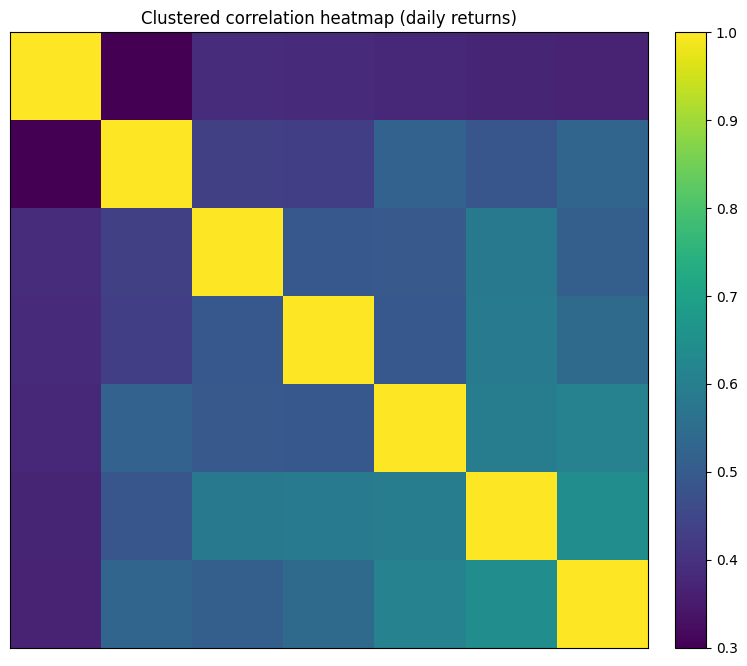

In [10]:
def clustered_heatmap(corr: pd.DataFrame, title: str):
    dist = 1 - corr.values
    Z = linkage(dist, method="average")
    order = leaves_list(Z)
    corr_ord = corr.iloc[order, order]

    fig, ax = plt.subplots(figsize=(9, 8))
    im = ax.imshow(corr_ord.values, aspect="auto")
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.show()

clustered_heatmap(corr, "Clustered correlation heatmap (daily returns)")


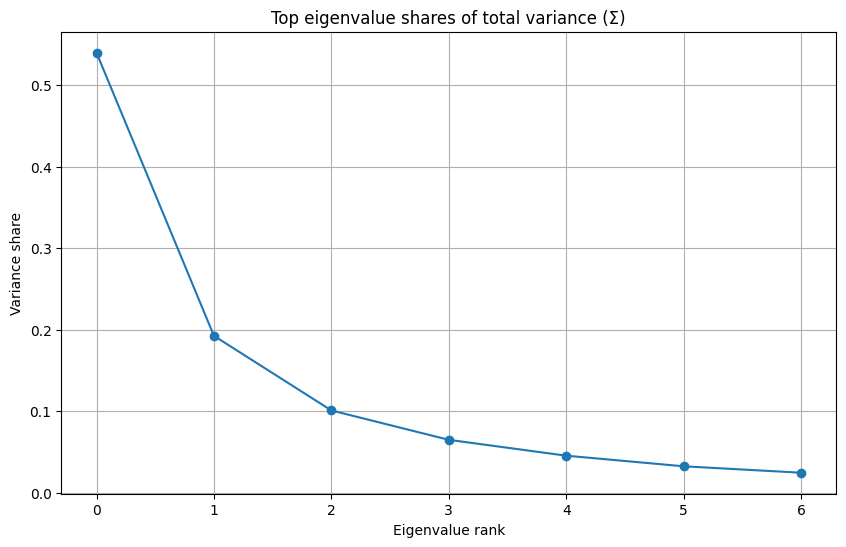

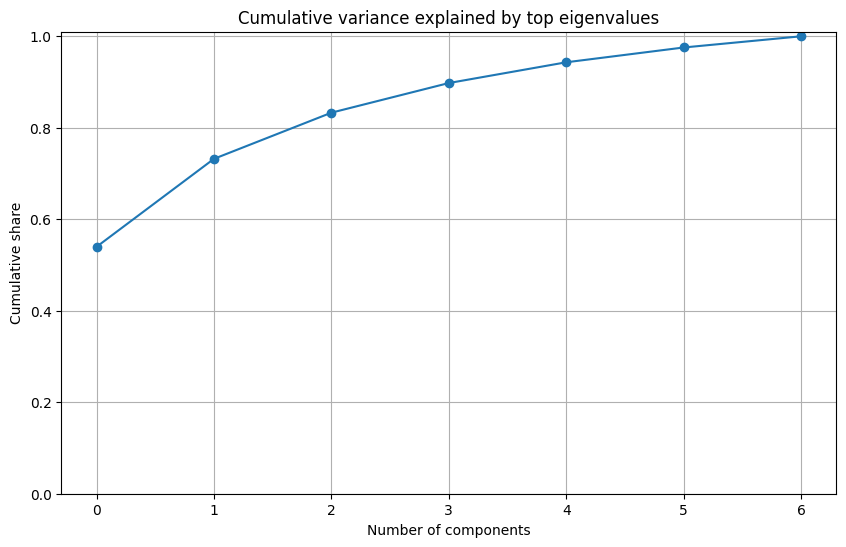

In [11]:
evals = np.linalg.eigvalsh(Sigma_lw.values)
evals = np.sort(evals)[::-1]
explained = evals / evals.sum()
cum_explained = np.cumsum(explained)

fig, ax = plt.subplots()
ax.plot(explained[:50], marker="o")
ax.set_title("Top eigenvalue shares of total variance (Σ)")
ax.set_xlabel("Eigenvalue rank")
ax.set_ylabel("Variance share")
plt.show()

fig, ax = plt.subplots()
ax.plot(cum_explained[:50], marker="o")
ax.set_title("Cumulative variance explained by top eigenvalues")
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative share")
ax.set_ylim(0, 1.01)
plt.show()


## 9) Efficient frontier

In [12]:
def solve_gmv(mu: pd.Series, Sigma: pd.DataFrame, long_only: bool = True, solver: str = "OSQP"):
    n = len(mu)
    w = cp.Variable(n)
    Sigma_np = Sigma.values
    objective = cp.Minimize(cp.quad_form(w, Sigma_np))
    constraints = [cp.sum(w) == 1]
    if long_only:
        constraints.append(w >= 0)
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=solver, verbose=False)
    if w.value is None:
        raise RuntimeError("GMV optimization failed. Try OSQP/ECOS/SCS.")
    return pd.Series(np.array(w.value).reshape(-1), index=mu.index)

def solve_frontier(mu: pd.Series, Sigma: pd.DataFrame, R_targets: np.ndarray,
                   long_only: bool = True, solver: str = "OSQP"):
    Sigma_np = Sigma.values
    mu_np = mu.values
    w = cp.Variable(len(mu))
    risk = cp.quad_form(w, Sigma_np)
    frontier = []
    weights = []
    for R in R_targets:
        constraints = [cp.sum(w) == 1, mu_np @ w >= R]
        if long_only:
            constraints.append(w >= 0)
        prob = cp.Problem(cp.Minimize(risk), constraints)
        prob.solve(solver=solver, verbose=False)
        if w.value is None:
            frontier.append((np.nan, np.nan))
            weights.append(np.full(len(mu), np.nan))
            continue
        wv = np.array(w.value).reshape(-1)
        frontier.append((float(np.sqrt(wv @ Sigma_np @ wv)), float(mu_np @ wv)))
        weights.append(wv)
    frontier = pd.DataFrame(frontier, columns=["sigma","mu"])
    W = pd.DataFrame(weights, columns=mu.index)
    return frontier, W

USE_SHRINKAGE = True
Sigma_use = Sigma_lw if USE_SHRINKAGE else Sigma

w_gmv = solve_gmv(mu, Sigma_use, long_only=LONG_ONLY)
mu_gmv = float(mu @ w_gmv)
sig_gmv = float(np.sqrt(w_gmv.values @ Sigma_use.values @ w_gmv.values))

R_targets = np.linspace(mu_gmv, float(mu.max()), N_FRONTIER)
frontier, W = solve_frontier(mu, Sigma_use, R_targets, long_only=LONG_ONLY)

mask = frontier.notna().all(axis=1)
frontier = frontier.loc[mask].reset_index(drop=True)
W = W.loc[mask].reset_index(drop=True)

frontier.head()


,sigma,mu
0,0.231047,0.219020
1,0.231808,0.223422
2,0.232800,0.227824
3,0.233924,0.232227
4,0.235177,0.236629


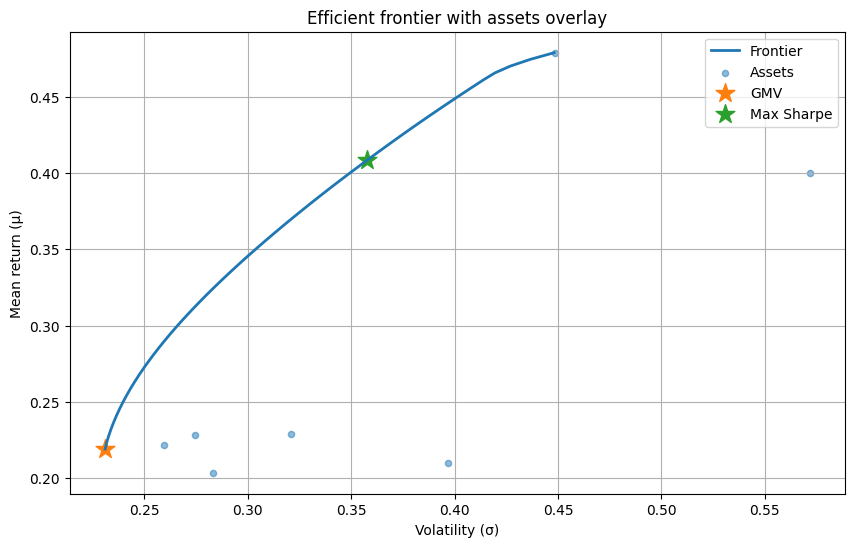

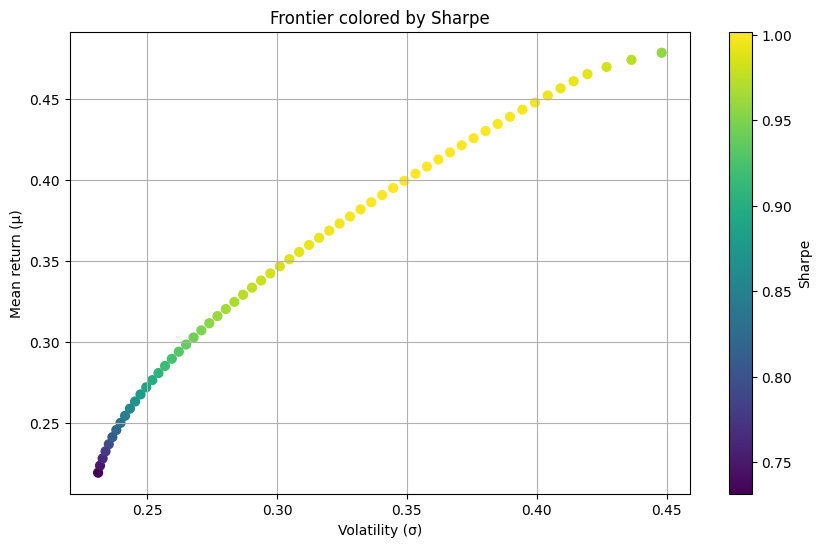

In [13]:
def sharpe(mu_p, sig_p, rf=RF):
    return (mu_p - rf) / sig_p

vol = np.sqrt(np.diag(Sigma.values))
asset_stats = pd.DataFrame({"mu": mu.values, "sigma": vol}, index=mu.index)

frontier["sharpe"] = frontier.apply(lambda r: sharpe(r["mu"], r["sigma"], RF) if r["sigma"] > 0 else np.nan, axis=1)

i_ms = int(frontier["sharpe"].idxmax())
w_ms = W.loc[i_ms]
mu_ms = float(mu @ w_ms)
sig_ms = float(np.sqrt(w_ms.values @ Sigma_use.values @ w_ms.values))
sh_ms = float(sharpe(mu_ms, sig_ms, RF))

fig, ax = plt.subplots()
ax.plot(frontier["sigma"], frontier["mu"], linewidth=2)
ax.scatter(asset_stats["sigma"], asset_stats["mu"], s=20, alpha=0.5)
ax.scatter([sig_gmv], [mu_gmv], marker="*", s=200)
ax.scatter([sig_ms], [mu_ms], marker="*", s=200)
ax.set_title("Efficient frontier with assets overlay")
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Mean return (μ)")
ax.legend(["Frontier","Assets","GMV","Max Sharpe"], loc="best")
plt.show()

fig, ax = plt.subplots()
sc = ax.scatter(frontier["sigma"], frontier["mu"], c=frontier["sharpe"], s=40)
ax.set_title("Frontier colored by Sharpe")
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Mean return (μ)")
fig.colorbar(sc, ax=ax, label="Sharpe")
plt.show()


In [14]:
# --- identify key frontier portfolios ---
i_gmv = None  # you already have w_gmv, mu_gmv, sig_gmv from your code

i_ms = int(frontier["sharpe"].idxmax())
w_ms = W.loc[i_ms]

i_maxret = int(frontier["mu"].idxmax())     # "biggest expected return" on the computed frontier grid
w_maxret = W.loc[i_maxret]

# Optional: equal-weight baseline
w_eq = pd.Series(1 / len(mu), index=mu.index)

# Add markers to your plot
mu_maxret = float(mu @ w_maxret)
sig_maxret = float(np.sqrt(w_maxret.values @ Sigma_use.values @ w_maxret.values))


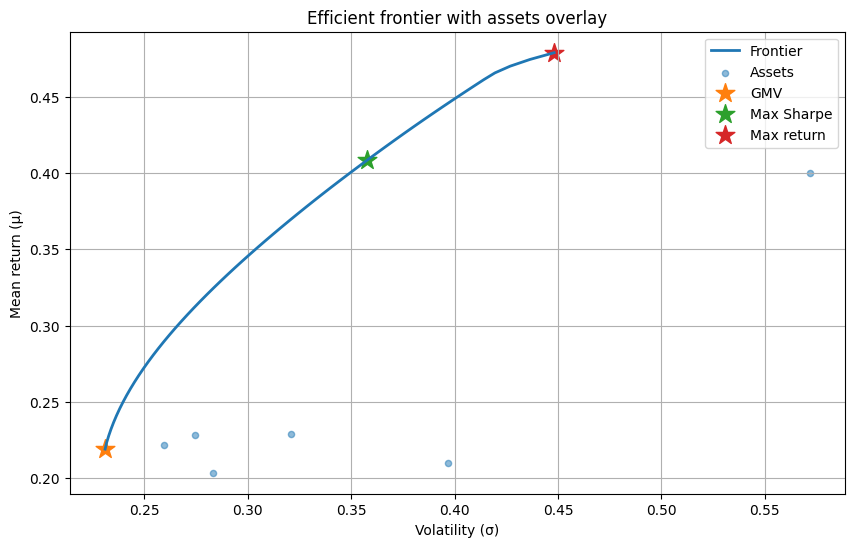

In [15]:
fig, ax = plt.subplots()
ax.plot(frontier["sigma"], frontier["mu"], linewidth=2)
ax.scatter(asset_stats["sigma"], asset_stats["mu"], s=20, alpha=0.5)

ax.scatter([sig_gmv],    [mu_gmv],    marker="*", s=200)
ax.scatter([sig_ms],     [mu_ms],     marker="*", s=200)
ax.scatter([sig_maxret], [mu_maxret], marker="*", s=200)

ax.set_title("Efficient frontier with assets overlay")
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Mean return (μ)")
ax.legend(["Frontier","Assets","GMV","Max Sharpe","Max return"], loc="best")
plt.show()


In [16]:
import numpy as np
import pandas as pd

TRADING_DAYS = 252

def to_simple_returns(log_rets: pd.DataFrame) -> pd.DataFrame:
    return np.exp(log_rets) - 1.0

def rf_daily(rf_annual: float) -> float:
    return (1.0 + rf_annual) ** (1.0 / TRADING_DAYS) - 1.0

def portfolio_simple_returns(simple_rets: pd.DataFrame, w: pd.Series) -> pd.Series:
    w = w.reindex(simple_rets.columns).fillna(0.0)
    return simple_rets @ w

def max_drawdown(wealth: pd.Series) -> float:
    peak = wealth.cummax()
    dd = wealth / peak - 1.0
    return float(dd.min())

def historical_var_cvar(r: pd.Series, alpha: float = 0.05) -> tuple[float, float]:
    # VaR and CVaR on return distribution (negative numbers represent losses)
    q = float(r.quantile(alpha))
    cvar = float(r[r <= q].mean()) if (r <= q).any() else q
    return q, cvar

def portfolio_metrics(
    r: pd.Series,
    rf_annual: float = 0.0,
    mar_annual: float | None = None,     # MAR = minimum acceptable return for Sortino; default=RF
) -> dict:
    """
    r: daily simple returns
    rf_annual: annual risk-free rate
    mar_annual: annual MAR for Sortino (if None => rf_annual)
    """
    r = r.dropna()
    rf_d = rf_daily(rf_annual)
    mar_a = rf_annual if mar_annual is None else mar_annual
    mar_d = rf_daily(mar_a)

    # excess returns
    ex = r - rf_d

    mu_d = float(r.mean())
    sig_d = float(r.std(ddof=1))

    ann_ret = float((1.0 + mu_d) ** TRADING_DAYS - 1.0)  # mean-based approx
    ann_vol = float(sig_d * np.sqrt(TRADING_DAYS))

    sharpe = float(ex.mean() / ex.std(ddof=1) * np.sqrt(TRADING_DAYS)) if ex.std(ddof=1) > 0 else np.nan

    downside = (r - mar_d).clip(upper=0.0)
    dd_d = float(np.sqrt((downside**2).mean()))
    sortino = float((r.mean() - mar_d) / dd_d * np.sqrt(TRADING_DAYS)) if dd_d > 0 else np.nan

    wealth = (1.0 + r).cumprod()
    mdd = max_drawdown(wealth)
    calmar = float(ann_ret / abs(mdd)) if mdd < 0 else np.nan

    var95, cvar95 = historical_var_cvar(r, alpha=0.05)

    win = float((r > 0).mean())
    skew = float(r.skew())
    kurt = float(r.kurtosis())

    return {
        "AnnReturn": ann_ret,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "Sortino(MAR=RF)": sortino,
        "MaxDrawdown": mdd,
        "Calmar": calmar,
        "VaR(5%)": var95,
        "CVaR(5%)": cvar95,
        "WinRate": win,
        "Skew": skew,
        "Kurtosis": kurt,
        "FinalWealth($1)": float(wealth.iloc[-1]),
    }


simple_rets = to_simple_returns(rets)

portfolios = {
    "GMV": w_gmv,
    "MaxSharpe": w_ms,
    "MaxReturn(frontier)": w_maxret,
    "EqualWeight": w_eq,
}

series = {name: portfolio_simple_returns(simple_rets, w) for name, w in portfolios.items()}

metrics = pd.DataFrame({name: portfolio_metrics(r, rf_annual=RF) for name, r in series.items()}).T
metrics


,AnnReturn,AnnVol,Sharpe,Sortino(MAR=RF),MaxDrawdown,Calmar,VaR(5%),CVaR(5%),WinRate,Skew,Kurtosis,FinalWealth($1)
GMV,0.293458,0.231305,0.902081,1.309718,-0.362832,0.808800,-0.022814,-0.033717,0.551133,0.016147,7.052321,23.331264
MaxSharpe,0.655750,0.359548,1.268159,1.899862,-0.564178,1.162311,-0.034765,-0.050988,0.553457,0.169980,6.028926,406.935709
MaxReturn(frontier),0.785228,0.451599,1.176748,1.814496,-0.663351,1.183729,-0.040854,-0.061446,0.538931,0.599265,9.377869,691.697573
EqualWeight,0.424605,0.268113,1.138880,1.647269,-0.493871,0.859749,-0.026895,-0.039461,0.561592,-0.133203,5.524960,76.939610


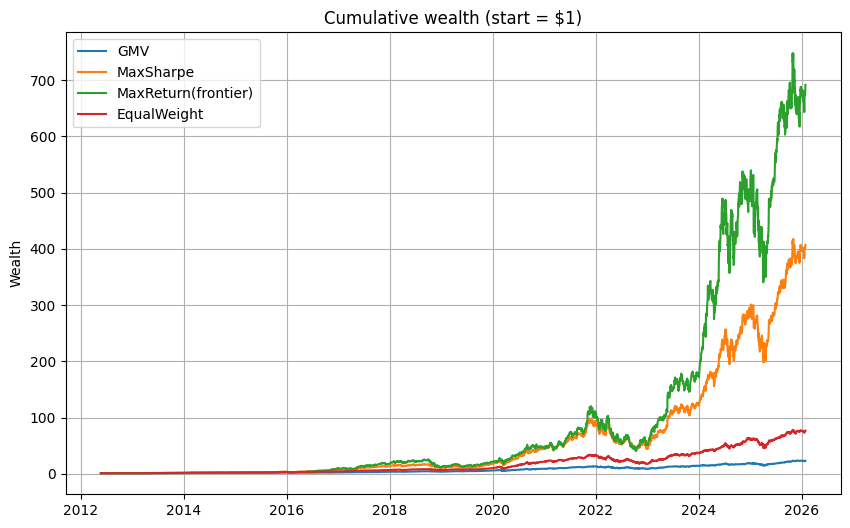

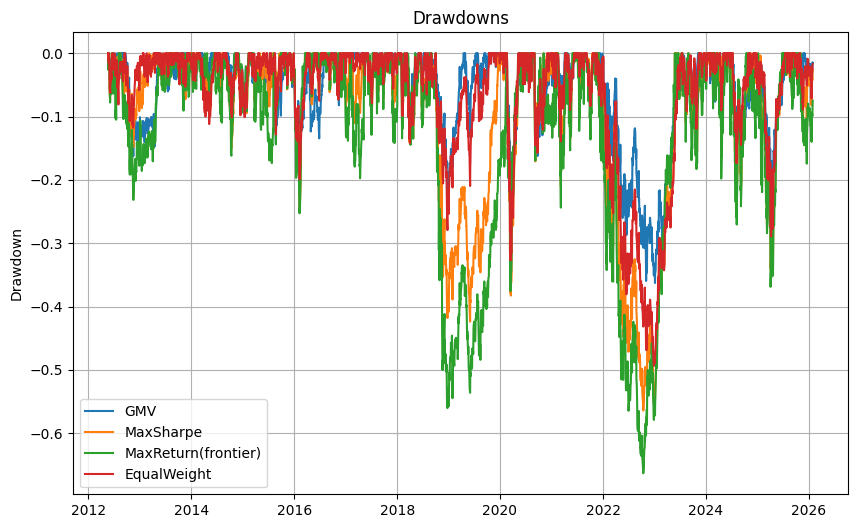

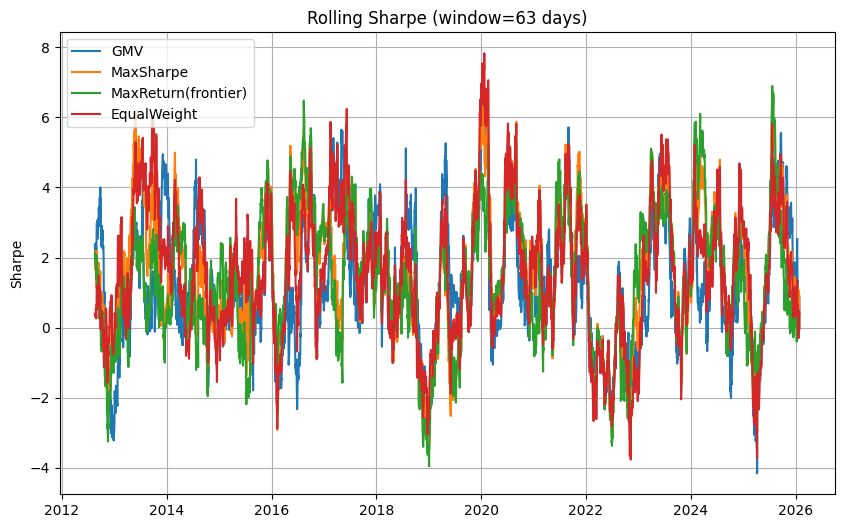

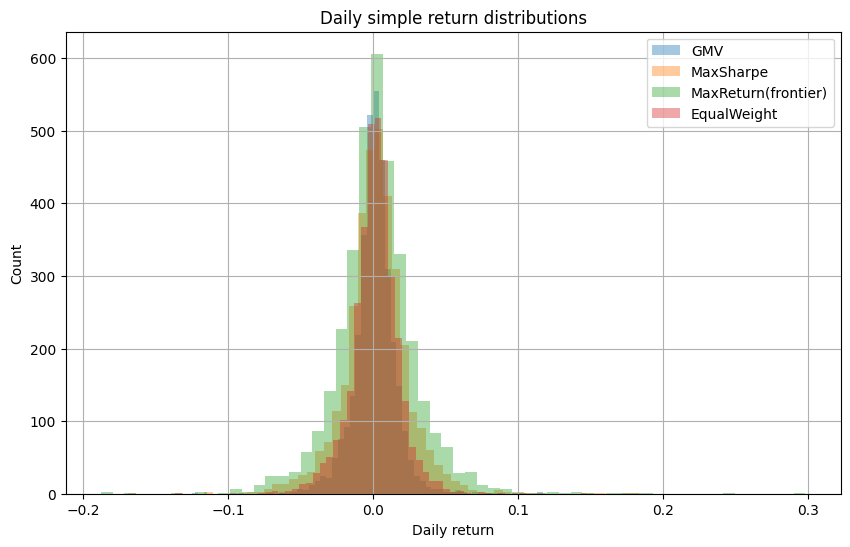

In [17]:
import matplotlib.pyplot as plt

def plot_cum_wealth(series: dict[str, pd.Series]):
    fig, ax = plt.subplots()
    for name, r in series.items():
        wealth = (1.0 + r.dropna()).cumprod()
        ax.plot(wealth.index, wealth.values, label=name)
    ax.set_title("Cumulative wealth (start = $1)")
    ax.set_ylabel("Wealth")
    ax.legend()
    plt.show()

def plot_drawdowns(series: dict[str, pd.Series]):
    fig, ax = plt.subplots()
    for name, r in series.items():
        wealth = (1.0 + r.dropna()).cumprod()
        dd = wealth / wealth.cummax() - 1.0
        ax.plot(dd.index, dd.values, label=name)
    ax.set_title("Drawdowns")
    ax.set_ylabel("Drawdown")
    ax.legend()
    plt.show()

def rolling_sharpe(r: pd.Series, rf_annual: float, window: int = 63) -> pd.Series:
    rf_d = rf_daily(rf_annual)
    ex = r - rf_d
    m = ex.rolling(window).mean()
    s = ex.rolling(window).std(ddof=1)
    return (m / s) * np.sqrt(TRADING_DAYS)

def plot_rolling_sharpe(series: dict[str, pd.Series], rf_annual: float, window: int = 63):
    fig, ax = plt.subplots()
    for name, r in series.items():
        rs = rolling_sharpe(r.dropna(), rf_annual, window=window)
        ax.plot(rs.index, rs.values, label=name)
    ax.set_title(f"Rolling Sharpe (window={window} days)")
    ax.set_ylabel("Sharpe")
    ax.legend()
    plt.show()

def plot_return_hists(series: dict[str, pd.Series], bins: int = 60):
    fig, ax = plt.subplots()
    for name, r in series.items():
        ax.hist(r.dropna().values, bins=bins, alpha=0.4, label=name)
    ax.set_title("Daily simple return distributions")
    ax.set_xlabel("Daily return")
    ax.set_ylabel("Count")
    ax.legend()
    plt.show()

plot_cum_wealth(series)
plot_drawdowns(series)
plot_rolling_sharpe(series, rf_annual=RF, window=63)
plot_return_hists(series, bins=60)


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# --- assumptions ---
# rets: daily LOG returns (as in your notebook: rets = log(P_t/P_{t-1}))
# W: DataFrame, each row i is weights for frontier point i (columns=tickers)
# frontier: DataFrame with columns ["sigma","mu"] aligned to W rows
# RF: annual risk-free rate (float)

def rf_daily(rf_annual: float) -> float:
    return (1.0 + rf_annual) ** (1.0 / TRADING_DAYS) - 1.0

def portfolio_simple_returns_from_logrets(rets_log: pd.DataFrame, w: pd.Series) -> pd.Series:
    # r_log,p = sum_i w_i r_log,i
    wv = w.reindex(rets_log.columns).fillna(0.0).to_numpy(dtype=float)
    rlog = rets_log.to_numpy(dtype=float) @ wv
    # convert log->simple
    rs = np.expm1(rlog)  # exp(rlog)-1
    return pd.Series(rs, index=rets_log.index, name="r_simple")

def max_drawdown_from_returns(r_simple: pd.Series) -> float:
    wealth = (1.0 + r_simple).cumprod()
    peak = wealth.cummax()
    dd = wealth / peak - 1.0
    return float(dd.min())  # negative

def historical_var_cvar(r_simple: pd.Series, alpha: float = 0.05) -> tuple[float, float]:
    q = float(r_simple.quantile(alpha))
    tail = r_simple[r_simple <= q]
    cvar = float(tail.mean()) if len(tail) > 0 else q
    return q, cvar

def realized_metrics(r_simple: pd.Series, rf_annual: float = 0.0, mar_annual: float | None = None,
                     alpha: float = 0.05) -> dict:
    """
    r_simple: daily SIMPLE returns
    rf_annual: annual RF for Sharpe/Sortino
    mar_annual: annual minimum acceptable return for Sortino (default = RF)
    alpha: tail probability for VaR/CVaR
    """
    r = r_simple.dropna().astype(float)
    if len(r) < 2:
        return {k: np.nan for k in [
            "CAGR","AnnVol","Sharpe","Sortino","MaxDrawdown","Calmar","VaR","CVaR","WinRate","Skew","Kurtosis","FinalWealth"
        ]}

    rf_d = rf_daily(rf_annual)
    mar_a = rf_annual if mar_annual is None else mar_annual
    mar_d = rf_daily(mar_a)

    # geometric annualized return (stable): exp(mean(log(1+r))*252)-1
    g = np.log1p(r).mean() * TRADING_DAYS
    ann_geo = float(np.expm1(g))

    # CAGR from endpoints (close to ann_geo if stationary)
    wealth = (1.0 + r).cumprod()
    years = len(r) / TRADING_DAYS
    cagr = float(wealth.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else np.nan

    ann_vol = float(r.std(ddof=1) * np.sqrt(TRADING_DAYS))

    # Sharpe on excess SIMPLE returns (daily), annualized
    ex = r - rf_d
    ex_std = ex.std(ddof=1)
    sharpe = float(ex.mean() / ex_std * np.sqrt(TRADING_DAYS)) if ex_std > 0 else np.nan

    # Sortino: downside deviation relative to MAR
    downside = (r - mar_d).clip(upper=0.0)
    dd = float(np.sqrt(np.mean(downside.to_numpy() ** 2)))
    sortino = float((r.mean() - mar_d) / dd * np.sqrt(TRADING_DAYS)) if dd > 0 else np.nan

    mdd = max_drawdown_from_returns(r)
    calmar = float(cagr / abs(mdd)) if (mdd < 0 and np.isfinite(cagr)) else np.nan

    var_a, cvar_a = historical_var_cvar(r, alpha=alpha)

    return {
        "AnnReturn(geo)": ann_geo,
        "CAGR": cagr,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "Sortino": sortino,
        "MaxDrawdown": mdd,
        "Calmar": calmar,
        f"VaR({int(alpha*100)}%)": var_a,
        f"CVaR({int(alpha*100)}%)": cvar_a,
        "WinRate": float((r > 0).mean()),
        "Skew": float(r.skew()),
        "Kurtosis": float(r.kurtosis()),
        "FinalWealth": float(wealth.iloc[-1]),
    }

def compute_frontier_metrics(rets_log: pd.DataFrame, W: pd.DataFrame, rf_annual: float = 0.0,
                             mar_annual: float | None = None, alpha: float = 0.05) -> pd.DataFrame:
    rows = []
    for i in range(len(W)):
        w = W.iloc[i]
        r_p = portfolio_simple_returns_from_logrets(rets_log, w)
        m = realized_metrics(r_p, rf_annual=rf_annual, mar_annual=mar_annual, alpha=alpha)
        rows.append(m)
    M = pd.DataFrame(rows)
    M.index = W.index  # align
    return M

# --- compute metrics for every frontier portfolio ---
M = compute_frontier_metrics(rets, W, rf_annual=RF, mar_annual=None, alpha=0.05)

# Join with frontier moments for convenience
out = frontier.copy()
out.index = W.index
out = out.join(M)

out.head()


,sigma,mu,sharpe,AnnReturn(geo),CAGR,AnnVol,Sharpe,Sortino,MaxDrawdown,Calmar,VaR(5%),CVaR(5%),WinRate,Skew,Kurtosis,FinalWealth
0,0.231047,0.219020,0.731537,0.244856,0.244856,0.231239,0.852142,1.232813,-0.370895,0.660176,-0.022852,-0.033820,0.550843,0.001533,7.050311,19.916187
1,0.231808,0.223422,0.748129,0.250348,0.250348,0.231993,0.869133,1.257128,-0.377511,0.663155,-0.022962,-0.034005,0.552005,-0.014893,6.938590,21.150465
2,0.232800,0.227824,0.763850,0.255865,0.255865,0.232987,0.885344,1.279991,-0.381873,0.670026,-0.023096,-0.034220,0.554329,-0.028207,6.944079,22.461236
3,0.233924,0.232227,0.779000,0.261405,0.261405,0.234112,0.901046,1.302202,-0.386300,0.676690,-0.023148,-0.034439,0.556072,-0.040943,6.938986,23.853241
4,0.235177,0.236629,0.793567,0.266971,0.266971,0.235367,0.916229,1.323747,-0.390696,0.683321,-0.023163,-0.034677,0.554038,-0.053010,6.923794,25.331512


In [19]:
def safe_idxmax(s: pd.Series):
    s2 = s.replace([np.inf, -np.inf], np.nan).dropna()
    return None if s2.empty else int(s2.idxmax())

def safe_idxmin(s: pd.Series):
    s2 = s.replace([np.inf, -np.inf], np.nan).dropna()
    return None if s2.empty else int(s2.idxmin())

# "Best" definitions:
# - Sharpe, Sortino, Calmar, CAGR: maximize
# - MaxDrawdown: maximize (closest to 0 is best, since it's negative)
# - CVaR: maximize (less negative tail loss is better); alternatively minimize abs(CVaR)
best = {
    "BestSharpe":        safe_idxmax(out["Sharpe"]),
    "BestSortino":       safe_idxmax(out["Sortino"]),
    "BestCalmar":        safe_idxmax(out["Calmar"]),
    "BestCAGR":          safe_idxmax(out["CAGR"]),
    "BestMaxDrawdown":   safe_idxmax(out["MaxDrawdown"]),   # least severe drawdown
    "BestCVaR(5%)":      safe_idxmax(out["CVaR(5%)"]),       # least bad tail loss
}

best = {k: v for k, v in best.items() if v is not None}
best


{'BestSharpe': 55,
 'BestSortino': 58,
 'BestCalmar': 56,
 'BestCAGR': 59,
 'BestMaxDrawdown': 0,
 'BestCVaR(5%)': 0}

In [20]:
# Summary table of the selected portfolios
summary_cols = [
    "sigma","mu","AnnReturn(geo)","CAGR","AnnVol","Sharpe","Sortino","MaxDrawdown","Calmar","VaR(5%)","CVaR(5%)","FinalWealth"
]
summary = out.loc[list(best.values()), summary_cols].copy()
summary.insert(0, "Label", list(best.keys()))
summary = summary.reset_index(drop=True)
summary


,Label,sigma,mu,AnnReturn(geo),CAGR,AnnVol,Sharpe,Sortino,MaxDrawdown,Calmar,VaR(5%),CVaR(5%),FinalWealth
0,BestSharpe,0.414186,0.461143,0.585886,0.585886,0.416096,1.199115,1.806924,-0.628684,0.931925,-0.039009,-0.058407,543.827711
1,BestSortino,0.436483,0.474350,0.606969,0.606969,0.439445,1.187373,1.818576,-0.654348,0.927594,-0.040195,-0.060406,651.332160
2,BestCalmar,0.419521,0.465546,0.592883,0.592883,0.421650,1.199115,1.813212,-0.635614,0.932773,-0.039285,-0.058956,577.530684
3,BestCAGR,0.448140,0.478752,0.614059,0.614059,0.451599,1.176748,1.814496,-0.663351,0.925693,-0.040854,-0.061446,691.697573
4,BestMaxDrawdown,0.231047,0.219020,0.244856,0.244856,0.231239,0.852142,1.232813,-0.370895,0.660176,-0.022852,-0.033820,19.916187
5,BestCVaR(5%),0.231047,0.219020,0.244856,0.244856,0.231239,0.852142,1.232813,-0.370895,0.660176,-0.022852,-0.033820,19.916187


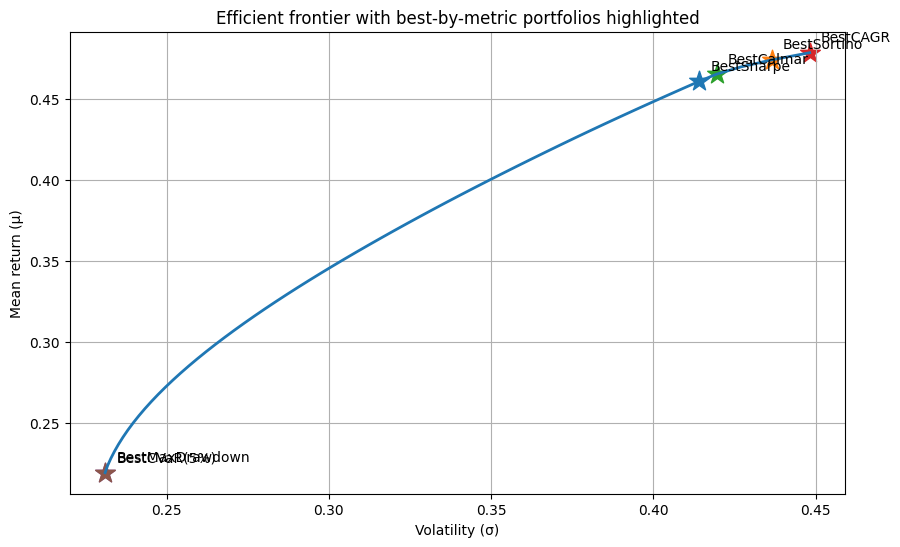

In [21]:
# Frontier plot with highlights
fig, ax = plt.subplots()
ax.plot(out["sigma"], out["mu"], linewidth=2)

for label, idx in best.items():
    ax.scatter([out.loc[idx, "sigma"]], [out.loc[idx, "mu"]], marker="*", s=220)
    ax.annotate(label, (out.loc[idx, "sigma"], out.loc[idx, "mu"]), xytext=(8, 8),
                textcoords="offset points")

ax.set_title("Efficient frontier with best-by-metric portfolios highlighted")
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Mean return (μ)")
plt.show()


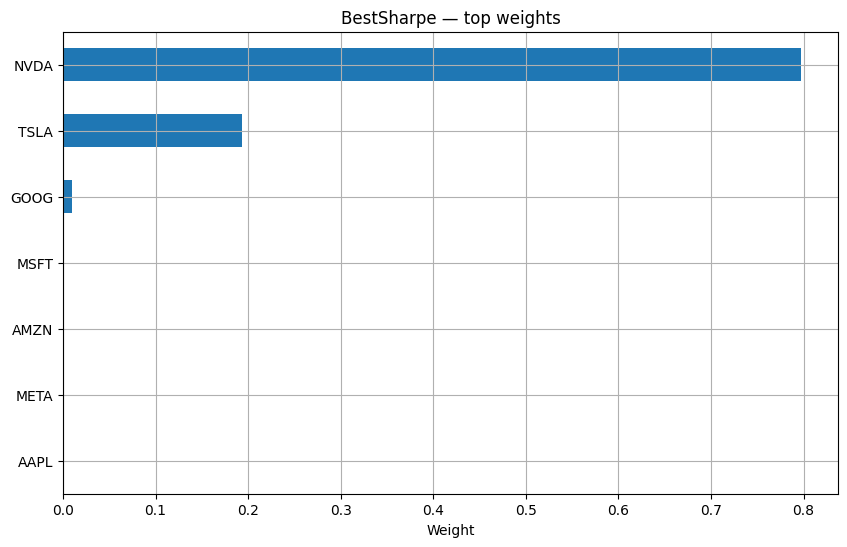

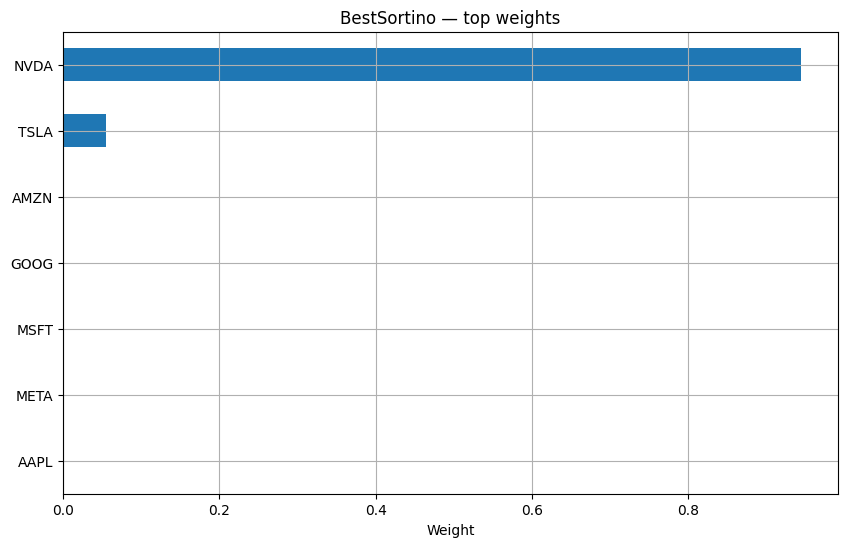

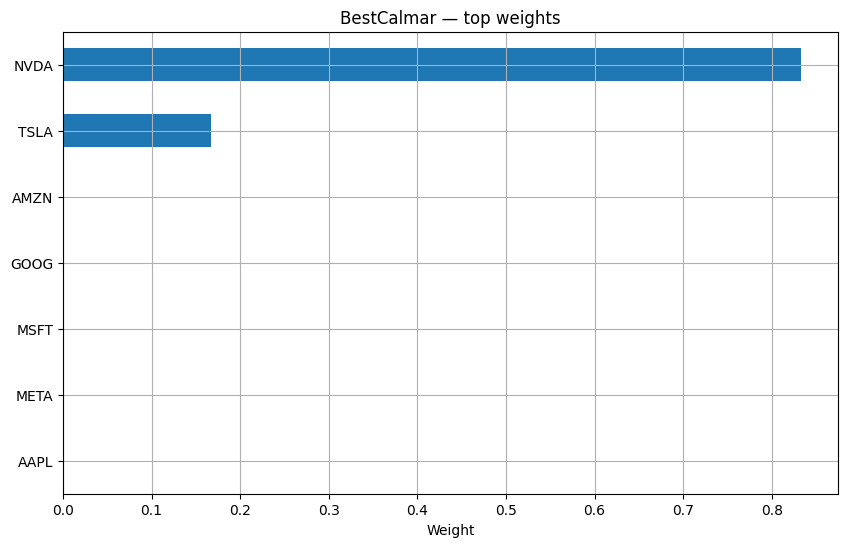

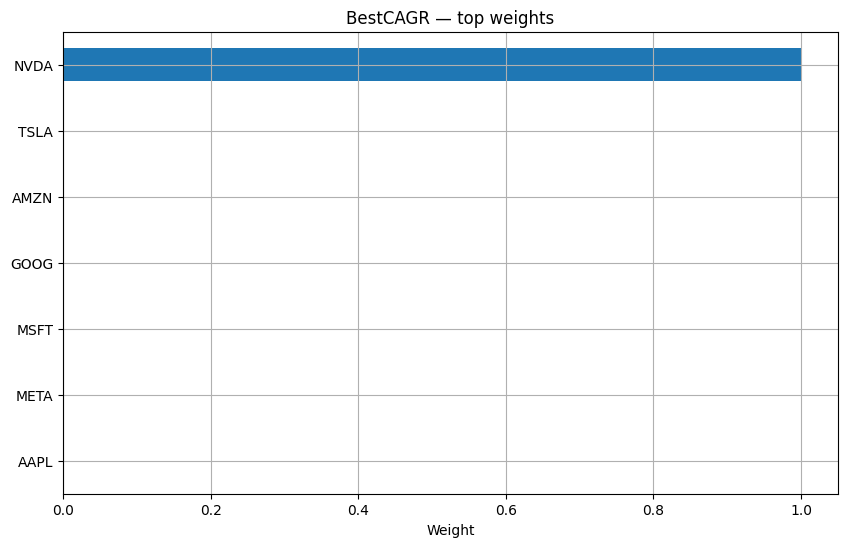

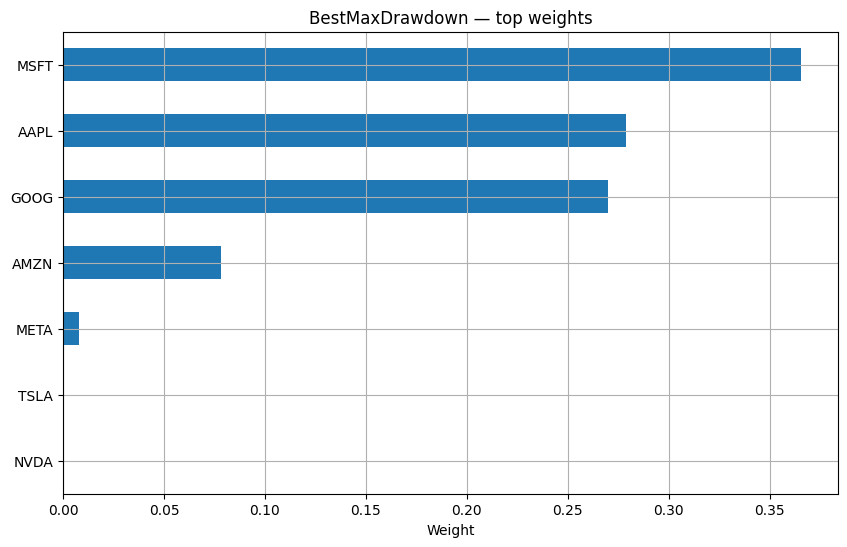

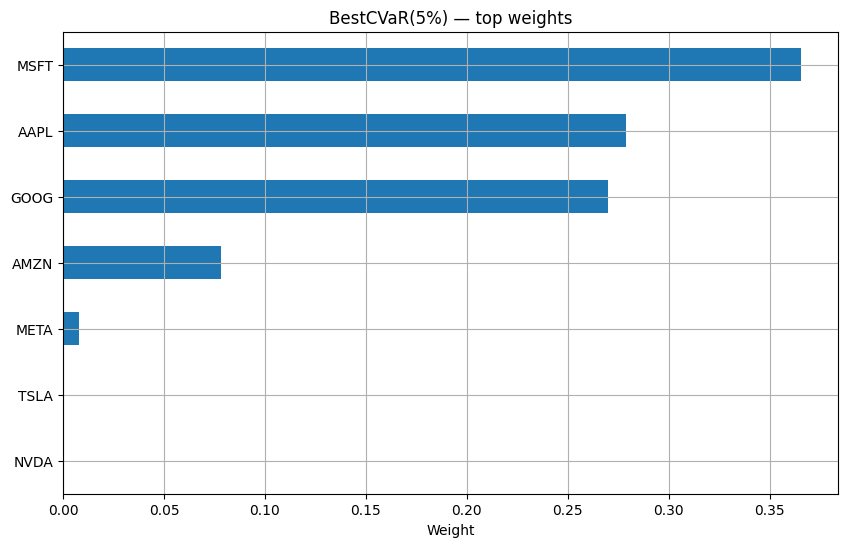

In [22]:
def plot_top_weights(w: pd.Series, title: str, k: int = 15):
    w = w.dropna()
    tw = w.sort_values(ascending=False).head(k)
    fig, ax = plt.subplots()
    tw.sort_values().plot(kind="barh", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Weight")
    plt.show()

# Plot top weights for each best portfolio
for label, idx in best.items():
    plot_top_weights(W.loc[idx], f"{label} — top weights", k=15)


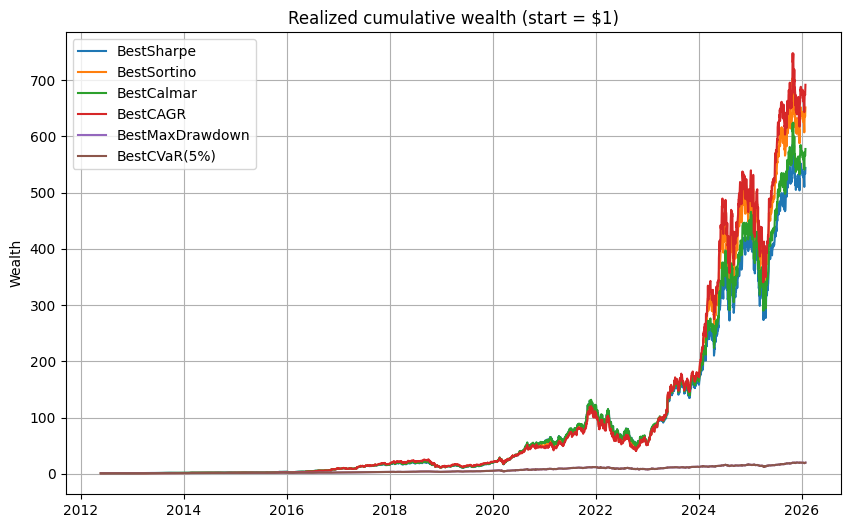

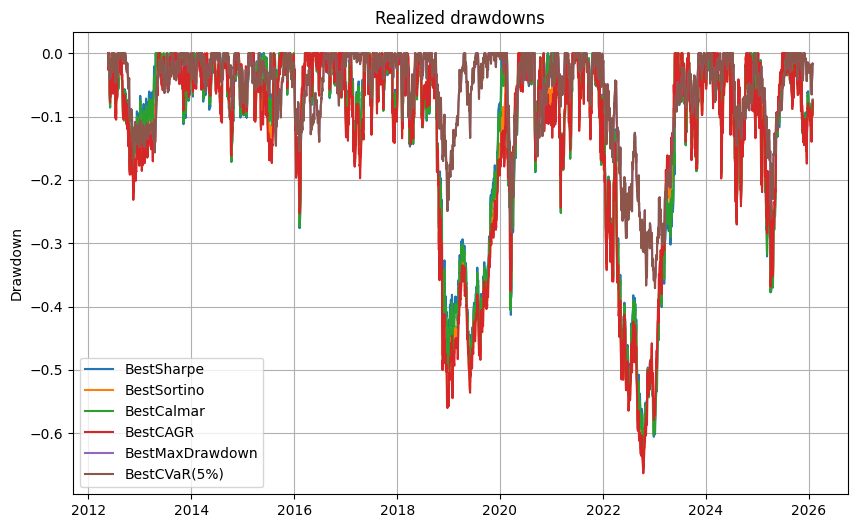

In [23]:
# Equity curves + drawdowns for the selected set
def equity_curve(r_simple: pd.Series) -> pd.Series:
    return (1.0 + r_simple.dropna()).cumprod()

def drawdown_curve(wealth: pd.Series) -> pd.Series:
    return wealth / wealth.cummax() - 1.0

sel = {label: W.loc[idx] for label, idx in best.items()}

# compute realized daily returns for each selected portfolio
series = {label: portfolio_simple_returns_from_logrets(rets, w) for label, w in sel.items()}

# Equity curves
fig, ax = plt.subplots()
for label, r in series.items():
    w = equity_curve(r)
    ax.plot(w.index, w.values, label=label)
ax.set_title("Realized cumulative wealth (start = $1)")
ax.set_ylabel("Wealth")
ax.legend()
plt.show()

# Drawdowns
fig, ax = plt.subplots()
for label, r in series.items():
    w = equity_curve(r)
    dd = drawdown_curve(w)
    ax.plot(dd.index, dd.values, label=label)
ax.set_title("Realized drawdowns")
ax.set_ylabel("Drawdown")
ax.legend()
plt.show()


## 10) Weights

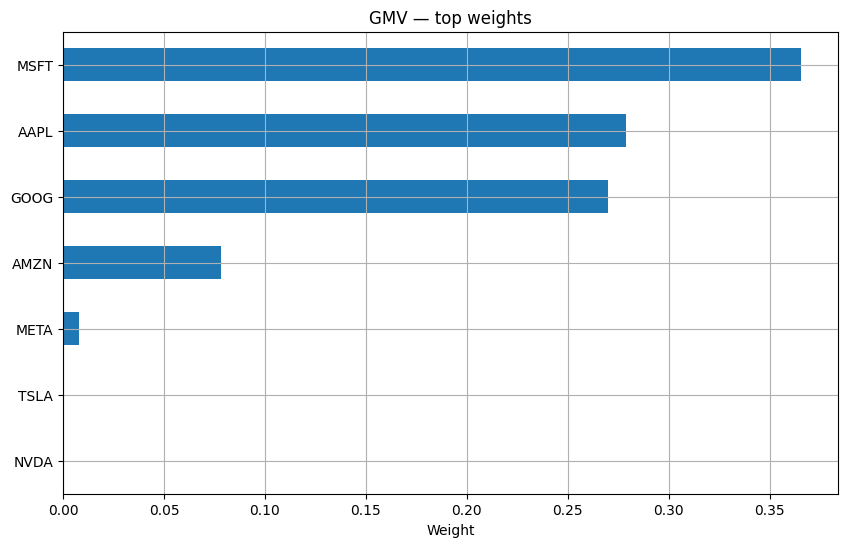

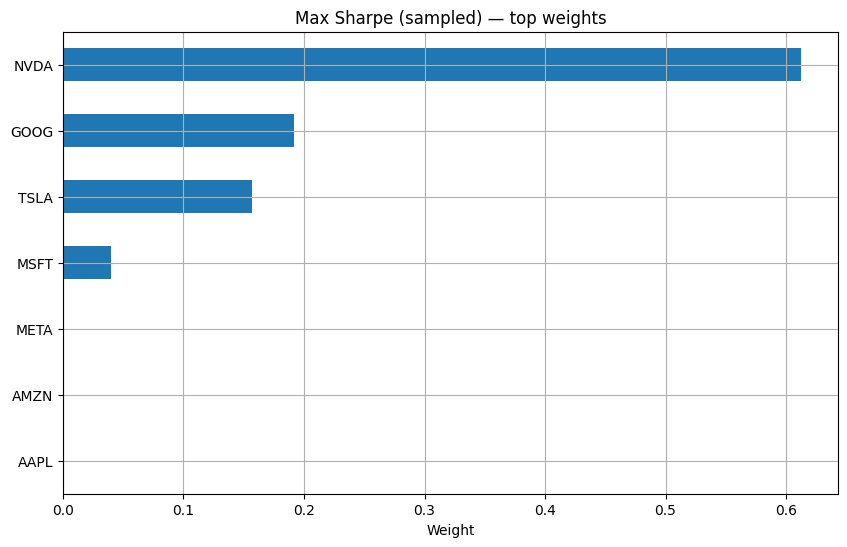

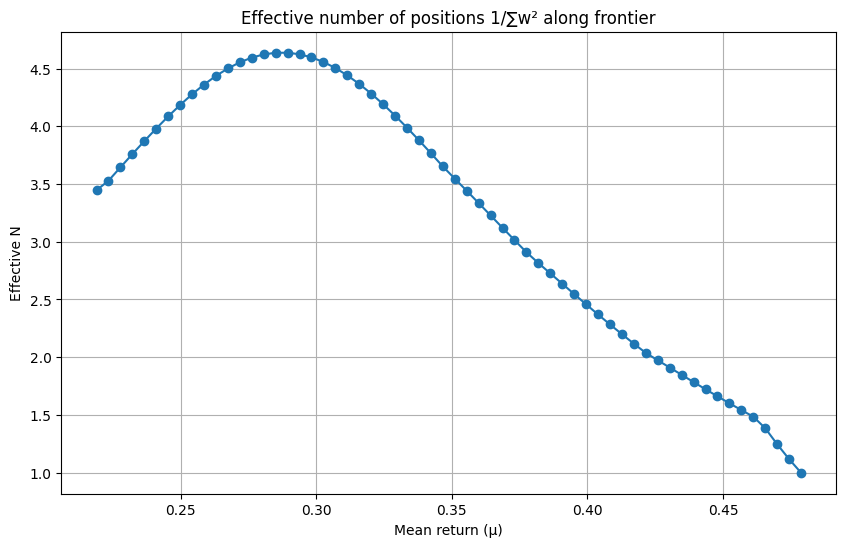

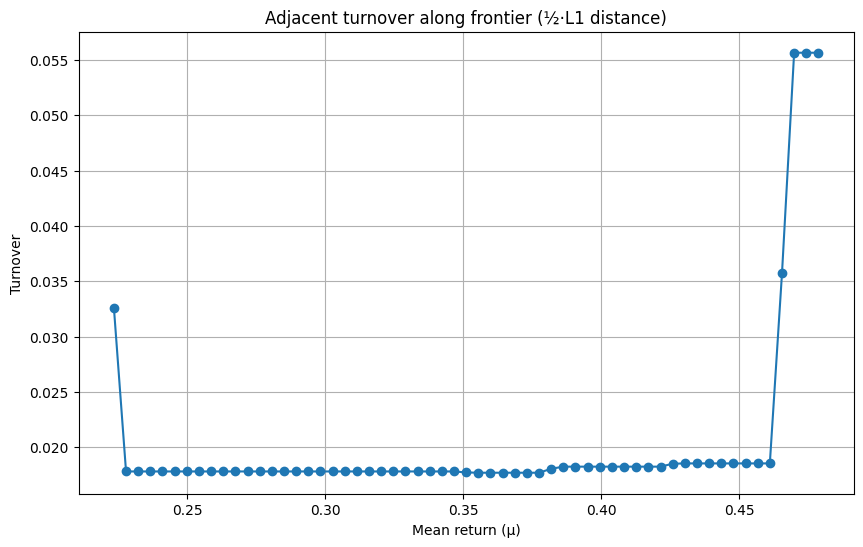

In [24]:
def plot_top_weights(w: pd.Series, title: str, k=15):
    tw = w.sort_values(ascending=False).head(k)
    fig, ax = plt.subplots()
    tw.sort_values().plot(kind="barh", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Weight")
    plt.show()

plot_top_weights(w_gmv, "GMV — top weights", k=15)
plot_top_weights(w_ms, "Max Sharpe (sampled) — top weights", k=15)

W_np = W.values
hhi = np.nansum(W_np**2, axis=1)
eff_n = 1 / hhi

fig, ax = plt.subplots()
ax.plot(frontier["mu"], eff_n, marker="o")
ax.set_title("Effective number of positions 1/∑w² along frontier")
ax.set_xlabel("Mean return (μ)")
ax.set_ylabel("Effective N")
plt.show()

turnover = np.nansum(np.abs(np.diff(W_np, axis=0)), axis=1) / 2.0
fig, ax = plt.subplots()
ax.plot(frontier["mu"].iloc[1:], turnover, marker="o")
ax.set_title("Adjacent turnover along frontier (½·L1 distance)")
ax.set_xlabel("Mean return (μ)")
ax.set_ylabel("Turnover")
plt.show()


In [25]:
w_gmv.sort_values(ascending=False).head(15)

MSFT    3.654572e-01
AAPL    2.786721e-01
GOOG    2.697562e-01
AMZN    7.827517e-02
META    7.839284e-03
TSLA    3.106727e-23
NVDA    8.039734e-24
dtype: float64

In [26]:
w_ms.sort_values(ascending=False).head(15)

NVDA    6.124456e-01
GOOG    1.914295e-01
TSLA    1.566710e-01
MSFT    3.945390e-02
META    2.340427e-23
AMZN    2.333600e-23
AAPL    1.397313e-23
Name: 43, dtype: float64

## 11) Simple out-of-sample sanity check

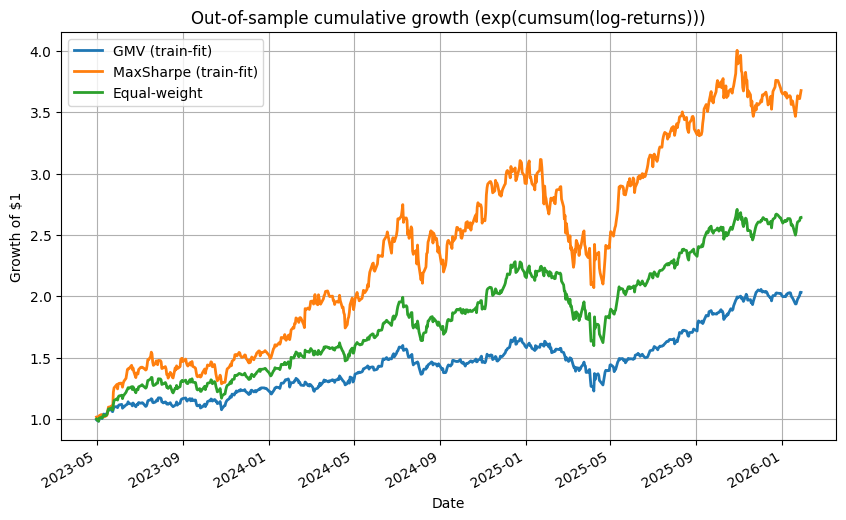

In [27]:
split = int(0.8 * len(rets))
rets_train = rets.iloc[:split]
rets_test  = rets.iloc[split:]

def moments_from_returns(rets_df: pd.DataFrame, use_shrinkage=True):
    mu_ = rets_df.mean() * ANNUALIZATION
    if use_shrinkage:
        lw_ = LedoitWolf().fit(rets_df.values)
        Sigma_ = pd.DataFrame(lw_.covariance_ * ANNUALIZATION, index=rets_df.columns, columns=rets_df.columns)
    else:
        Sigma_ = rets_df.cov() * ANNUALIZATION
    return mu_, Sigma_

mu_tr, Sigma_tr = moments_from_returns(rets_train, use_shrinkage=True)

w_gmv_tr = solve_gmv(mu_tr, Sigma_tr, long_only=LONG_ONLY)
R_targets_tr = np.linspace(float(mu_tr @ w_gmv_tr), float(mu_tr.max()), N_FRONTIER)
frontier_tr, W_tr = solve_frontier(mu_tr, Sigma_tr, R_targets_tr, long_only=LONG_ONLY)
frontier_tr["sharpe"] = (frontier_tr["mu"] - RF) / frontier_tr["sigma"]
i_ms_tr = int(frontier_tr["sharpe"].idxmax())
w_ms_tr = W_tr.loc[i_ms_tr]

w_eq = pd.Series(1/len(mu_tr), index=mu_tr.index)

def realized_portfolio_returns(rets_df: pd.DataFrame, w: pd.Series):
    w = w.reindex(rets_df.columns).fillna(0.0).values
    return rets_df.values @ w

r_gmv = realized_portfolio_returns(rets_test, w_gmv_tr)
r_ms  = realized_portfolio_returns(rets_test, w_ms_tr)
r_eq  = realized_portfolio_returns(rets_test, w_eq)

cum = pd.DataFrame({
    "GMV (train-fit)": np.exp(np.cumsum(r_gmv)),
    "MaxSharpe (train-fit)": np.exp(np.cumsum(r_ms)),
    "Equal-weight": np.exp(np.cumsum(r_eq)),
}, index=rets_test.index)

fig, ax = plt.subplots()
cum.plot(ax=ax, linewidth=2)
ax.set_title("Out-of-sample cumulative growth (exp(cumsum(log-returns)))")
ax.set_ylabel("Growth of $1")
plt.show()
